In [14]:
# !pip install plotly
# !pip install optuna
# !pip install xgboost
# !pip install catboost
# !pip install shap


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import plotly.express as px
import plotly.graph_objects as go
import logging
import shap
import seaborn as sns
import plotly.io as pio

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# #Set up logging
logger = logging.getLogger(optuna.__name__)
logger.setLevel(logging.DEBUG)

handler = logging.StreamHandler()
logger.addHandler(handler)

In [2]:
pio.renderers.default = 'pdf'

In [3]:
train_df = pd.read_csv("processed_train.csv")
test_df = pd.read_csv("processed_test.csv")

In [4]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
X_train = train_df.drop("TARGET", axis=1)
y_train = train_df["TARGET"]

X_test = test_df

## Choice of metric

Our target variable is quite unbalanced (9% of defaulters vs 91% the rest).
This fact tells us that we shouldn't chose accuracy since this metric is not relevant for unbalanced data. We are interested in both catching potential defaulters and avoiding false-positive default predictions because it is essentially lose of money for the bank. I consider two metric that might fit well to our goals: **F1-score** and **AUC** (Area under ROC curve) because these metrics will lead us to good combination of both **precision** and **recall**. I chose to go with **AUC** although *F1-score* would be a good metric as well.

Chosen metric - **AUC**



## Discovering Important Features in Data

In order to get a better understanding of our features, I will train a small *Random Forest* model to compute feature importance from the trees as well as SHAP importance.

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_discover = RandomForestClassifier(max_depth=20, n_jobs=-1, n_estimators=50)
rf_discover.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=50, n_jobs=-1)

In [7]:
feature_importances = pd.DataFrame({"feature" : X_train.columns,
                                     "importance" : rf_discover.feature_importances_})
feature_importances = feature_importances.sort_values(by="importance", ascending=False)

In [8]:
feature_importances.head(15)

,feature,importance
28,EXT_SOURCE_2,0.046384
29,EXT_SOURCE_3,0.039071
27,EXT_SOURCE_1,0.019155
7,DAYS_BIRTH,0.017915
89,DAYS_CREDIT_mean,0.016944
10,DAYS_ID_PUBLISH,0.015036
128,AMT_PAYMENT_mean,0.015027
129,NUM_INSTALMENT_NUMBER_std,0.014479
9,DAYS_REGISTRATION,0.014455
99,DAYS_CREDIT_UPDATE_mean,0.014214


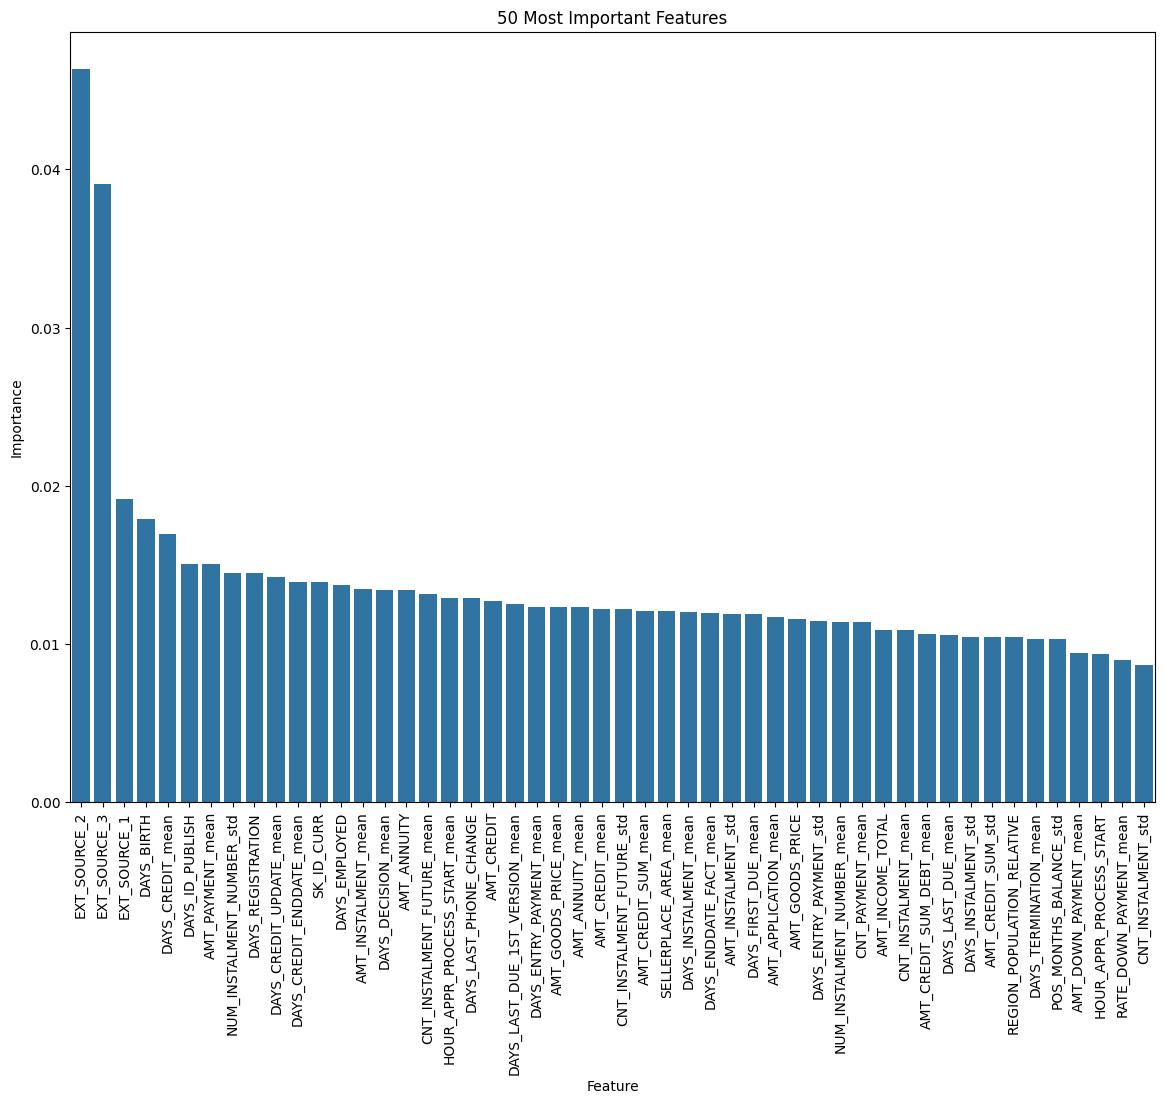

In [13]:
plt.figure(figsize=(14, 10))
sns.barplot(y='importance', x='feature', data=feature_importances[:50])
plt.xticks(rotation=90)
plt.title('50 Most Important Features')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

## Hand-crafted features

In [14]:
# Adding a small constant to avoid division by zero
epsilon = 1e-6

train_df["EXT_SOUCE_AVG"] = (train_df["EXT_SOURCE_1"] + train_df["EXT_SOURCE_2"] + train_df["EXT_SOURCE_3"]) / 3
train_df["LABOR_PERIOD_RATE"] = train_df["DAYS_EMPLOYED"] / (train_df["DAYS_BIRTH"] + epsilon)
train_df["CURR_VS_PREV_GOODS_PRICE"] = train_df["AMT_GOODS_PRICE"] / (train_df["AMT_GOODS_PRICE_mean"] + epsilon)
train_df["CURR_VS_PREV_ANNUITY"] = train_df["AMT_ANNUITY"] / (train_df["AMT_ANNUITY_mean"] + epsilon)
train_df["CONSUMPTION_RATE"] = train_df["AMT_GOODS_PRICE"] / (train_df["AMT_INCOME_TOTAL"] + epsilon)
train_df["CURR_REGISTRATION_PERIOD"] = train_df["DAYS_REGISTRATION"] / (train_df["DAYS_BIRTH"] + epsilon)
train_df["CREDIT_LOAD"] = train_df["AMT_CREDIT"] / (train_df["AMT_INCOME_TOTAL"] + epsilon)
train_df["CREDIT_LOAD_MEAN"] = train_df["AMT_CREDIT_mean"] / (train_df["AMT_INCOME_TOTAL"] + epsilon)
train_df["DECISION_ACTION_TIME"] = (- train_df["DAYS_DECISION_mean"]) - (- train_df["DAYS_ENTRY_PAYMENT_mean"])
train_df["PAYMENT_ANNUITY_RATIO"] = train_df["AMT_PAYMENT_mean"] / (train_df["AMT_ANNUITY_mean"] + epsilon)

# Applying the same changes to test_df
test_df["EXT_SOUCE_AVG"] = (test_df["EXT_SOURCE_1"] + test_df["EXT_SOURCE_2"] + test_df["EXT_SOURCE_3"]) / 3
test_df["LABOR_PERIOD_RATE"] = test_df["DAYS_EMPLOYED"] / (test_df["DAYS_BIRTH"] + epsilon)
test_df["CURR_VS_PREV_GOODS_PRICE"] = test_df["AMT_GOODS_PRICE"] / (test_df["AMT_GOODS_PRICE_mean"] + epsilon)
test_df["CURR_VS_PREV_ANNUITY"] = test_df["AMT_ANNUITY"] / (test_df["AMT_ANNUITY_mean"] + epsilon)
test_df["CONSUMPTION_RATE"] = test_df["AMT_GOODS_PRICE"] / (test_df["AMT_INCOME_TOTAL"] + epsilon)
test_df["CURR_REGISTRATION_PERIOD"] = test_df["DAYS_REGISTRATION"] / (test_df["DAYS_BIRTH"] + epsilon)
test_df["CREDIT_LOAD"] = test_df["AMT_CREDIT"] / (test_df["AMT_INCOME_TOTAL"] + epsilon)
test_df["CREDIT_LOAD_MEAN"] = test_df["AMT_CREDIT_mean"] / (test_df["AMT_INCOME_TOTAL"] + epsilon)
test_df["DECISION_ACTION_TIME"] = (- test_df["DAYS_DECISION_mean"]) - (- test_df["DAYS_ENTRY_PAYMENT_mean"])
test_df["PAYMENT_ANNUITY_RATIO"] = test_df["AMT_PAYMENT_mean"] / (test_df["AMT_ANNUITY_mean"] + epsilon)


## Choice of models

Overall, our training data has 177 features which tells us that we deal with
a high dimensional data. For this problem, **tree-based ensembles** would be a nice choise because of predictive power and efficiencty and computation. Another advantage of such models is ability to interpret results and analyze feature importance.

Models to consider:
  - RandomForest
  - Catboost
  - Xgboost
  - LightGBM
  

## Optuna framework for Hyperparameters tuning

Optuna is an open-source hyperparameter optimization framework designed for machine learning. It provides an efficient way to search for the best set of parameters for a given model to improve its performance. Optuna uses *Bayesian Optimization* under the hood. Bayesian optimization in Optuna is a sophisticated approach to hyperparameter tuning, using probabilistic models to guide the search for the best hyperparameters. It's particularly effective for optimizing complex functions where evaluations (like training and validating a machine learning model) are expensive in terms of time and computational resources. We need to define an objective function that we want to optimize. In our case, we are interested in maximizing **AUC** on cross-validation.

## Tunning for RandomForest

In [21]:

def rf_objective(trial):
    # Define the hyperparameter grid
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 14)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 14)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
    return np.mean(scores)

rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=10, timeout= 2400)


rf_trial = rf_study.best_trial
print(f'Best trial: {rf_trial.params}')

##Saving study
rf_study_df = rf_study.trials_dataframe()
rf_study_df.to_csv("rf_study.csv", index=False)

[I 2024-01-17 08:10:20,515] A new study created in memory with name: no-name-73ec1d17-03db-4d96-8ebd-e8277869be66
A new study created in memory with name: no-name-73ec1d17-03db-4d96-8ebd-e8277869be66
A new study created in memory with name: no-name-73ec1d17-03db-4d96-8ebd-e8277869be66
[I 2024-01-17 08:13:19,369] Trial 0 finished with value: 0.7307528841367041 and parameters: {'n_estimators': 847, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7307528841367041.
Trial 0 finished with value: 0.7307528841367041 and parameters: {'n_estimators': 847, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7307528841367041.
Trial 0 finished with value: 0.7307528841367041 and parameters: {'n_estimators': 847, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7307528841367041.
[I 2024-01-17 08:14:47,287] Trial 1 finished with value: 0.7195017656675763 and parameter

Best trial: {'n_estimators': 632, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 13}


In [22]:
rf_best_params = {'n_estimators': 568,
                  'max_depth': 14,
                  'min_samples_split': 7,
                  'min_samples_leaf': 10}



### Reduce the size of model
I think, it is a good idea to try to traing  following models on reduced data that contains top *K* most important features according to feature importance. This will allow us to iterate faster over models and set of hyperparameters

In [15]:
X_train = train_df.drop("TARGET", axis=1)
y_train = train_df["TARGET"]

X_test = test_df



In [16]:
rf_best_model = RandomForestClassifier(n_estimators=50,
                                      max_depth=14,
                                      min_samples_split=7,
                                      min_samples_leaf=10,
                                      n_jobs=-1)
rf_best_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=14, min_samples_leaf=10, min_samples_split=7,
                       n_estimators=50, n_jobs=-1)

In [17]:
new_feature_importances = pd.DataFrame({"feature" : X_train.columns,
                                     "importance" : rf_best_model.feature_importances_})
new_feature_importances = new_feature_importances.sort_values(by="importance", ascending=False)

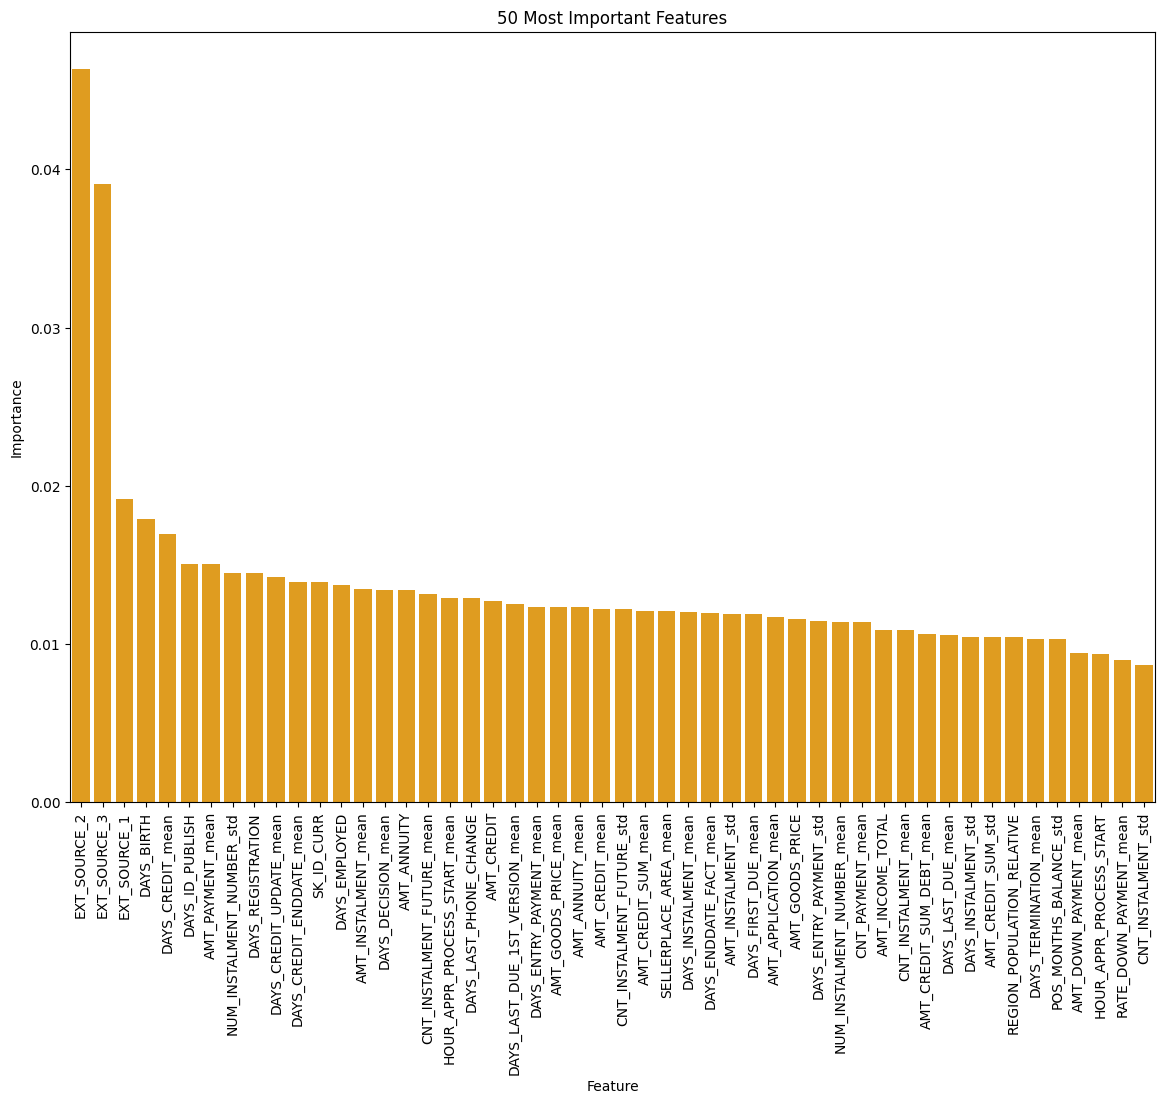

In [22]:
plt.figure(figsize=(14, 10))
sns.barplot(y='importance', x='feature', data=feature_importances[:50], color='orange')
plt.xticks(rotation=90)
plt.title('50 Most Important Features')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

First of all, we can see that some of handcrafted features turned out to be successful combination. The most useful feature turned out to be **EXT_SOURCE_AVG** the average of External scoring sources which is a hand-crafted feature.
**PAYMENT_ANNUITY_RATIO** is also among top of features.
Overall, *Feature engineering* gave us a bit more useful columns to consider.

Now, I suggest to use only first 75 features that are most important in order to make training iterations faster.

In [29]:
TOP_75_FEATS = new_feature_importances[:75]["feature"].values
TOP_75_FEATS

array(['EXT_SOUCE_AVG', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1',
       'DAYS_CREDIT_mean', 'DAYS_BIRTH', 'DAYS_CREDIT_UPDATE_mean',
       'PAYMENT_ANNUITY_RATIO', 'AMT_PAYMENT_mean',
       'DAYS_CREDIT_ENDDATE_mean', 'LABOR_PERIOD_RATE', 'DAYS_EMPLOYED',
       'CNT_INSTALMENT_FUTURE_mean', 'DAYS_ID_PUBLISH',
       'NUM_INSTALMENT_NUMBER_std', 'CURR_VS_PREV_ANNUITY',
       'AMT_INSTALMENT_mean', 'DAYS_DECISION_mean', 'AMT_CREDIT',
       'AMT_GOODS_PRICE', 'DAYS_ENTRY_PAYMENT_mean',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_INSTALMENT_mean', 'AMT_ANNUITY',
       'CNT_INSTALMENT_FUTURE_std', 'HOUR_APPR_PROCESS_START_mean',
       'DAYS_LAST_DUE_1ST_VERSION_mean', 'CNT_INSTALMENT_mean',
       'AMT_CREDIT_SUM_DEBT_mean', 'DAYS_REGISTRATION',
       'DECISION_ACTION_TIME', 'AMT_CREDIT_SUM_mean',
       'SELLERPLACE_AREA_mean', 'AMT_INSTALMENT_std', 'CNT_PAYMENT_mean',
       'CURR_REGISTRATION_PERIOD', 'CREDIT_LOAD', 'DAYS_FIRST_DUE_mean',
       'DAYS_ENDDATE_FACT_mean', 'NAME_

In [30]:
##Leave only important features

X_reduced_train = X_train[TOP_75_FEATS]
X_reduced_test = X_test[TOP_75_FEATS]

## Tunning for LightGBM

 *Using reduced data*

In [32]:
import lightgbm as lgb


def lgbm_objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'device' : 'gpu',
        'n_jobs' : -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 900),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    clf = lgb.LGBMClassifier(**param)
    scores = cross_val_score(clf, X_reduced_train, y_train, cv=3, scoring='roc_auc')
    return np.mean(scores)

lgbm_study = optuna.create_study(direction="maximize")
lgbm_study.optimize(lgbm_objective, n_trials=30, timeout=2400)

# Best trial
lgbm_trial = lgbm_study.best_trial
print(f'Best trial for Gradient Boosting: {lgbm_trial.params}')

##Saving study
lgbm_study_df = lgbm_study.trials_dataframe()
lgbm_study_df.to_csv("lgbm_study.csv", index=False)

[I 2024-01-17 08:30:11,044] A new study created in memory with name: no-name-cfd18be7-acee-445b-a96e-e9cd01556dbb
A new study created in memory with name: no-name-cfd18be7-acee-445b-a96e-e9cd01556dbb
A new study created in memory with name: no-name-cfd18be7-acee-445b-a96e-e9cd01556dbb
[I 2024-01-17 08:30:28,486] Trial 0 finished with value: 0.7646595419413901 and parameters: {'n_estimators': 149, 'learning_rate': 0.03349658609613983, 'max_depth': 6, 'num_leaves': 270, 'min_child_samples': 24, 'subsample': 0.6340653331863051, 'colsample_bytree': 0.9836045200886179, 'reg_alpha': 0.8404283814848802, 'reg_lambda': 0.456204612722494}. Best is trial 0 with value: 0.7646595419413901.
Trial 0 finished with value: 0.7646595419413901 and parameters: {'n_estimators': 149, 'learning_rate': 0.03349658609613983, 'max_depth': 6, 'num_leaves': 270, 'min_child_samples': 24, 'subsample': 0.6340653331863051, 'colsample_bytree': 0.9836045200886179, 'reg_alpha': 0.8404283814848802, 'reg_lambda': 0.45620461

Best trial for Gradient Boosting: {'n_estimators': 697, 'learning_rate': 0.03930423057245522, 'max_depth': 4, 'num_leaves': 176, 'min_child_samples': 75, 'subsample': 0.8462769546391864, 'colsample_bytree': 0.9284704246901986, 'reg_alpha': 0.5117007793859593, 'reg_lambda': 0.9136155128413382}


In [35]:
lgbm_best_params = {'n_estimators': 697, 'learning_rate': 0.03930423057245522, 'max_depth': 4,
                    'num_leaves': 176, 'min_child_samples': 75, 'subsample': 0.8462769546391864,
                    'colsample_bytree': 0.9284704246901986, 'reg_alpha': 0.5117007793859593, 'reg_lambda': 0.9136155128413382}


## Tunning for XGBoost
---



In [37]:
from xgboost import XGBClassifier

def xgb_objective(trial):

    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 800),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'device' : 'cuda'
    }


    clf = XGBClassifier(**param)
    scores = cross_val_score(clf, X_reduced_train, y_train, cv=3, scoring='roc_auc')
    return np.mean(scores)

In [38]:
xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=30, timeout=2400)

# Best trial
xgb_trial = xgb_study.best_trial
print(f'Best trial for Gradient Boosting: {xgb_trial.params}')

##Saving study
xgb_study_df = xgb_study.trials_dataframe()
xgb_study_df.to_csv("xgb_study.csv", index=False)

[I 2024-01-17 08:42:29,998] A new study created in memory with name: no-name-8a05d7ee-ec75-4d36-81dc-8490b2330415
A new study created in memory with name: no-name-8a05d7ee-ec75-4d36-81dc-8490b2330415
A new study created in memory with name: no-name-8a05d7ee-ec75-4d36-81dc-8490b2330415
C:\ProgramData\anaconda3\envs\cudatest\Lib\site-packages\xgboost\core.py:160: UserWarning:

[08:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


[I 2024-01-17 08:42:37,092] Trial 0 finished with value: 0.71514837684

Best trial for Gradient Boosting: {'max_depth': 2, 'learning_rate': 0.09797757887635654, 'n_estimators': 613, 'min_child_weight': 3, 'gamma': 0.07138018051833753, 'subsample': 0.32256266579235704, 'colsample_bytree': 0.6174856008223548, 'reg_alpha': 0.013610359445367834, 'reg_lambda': 4.7169144412554967e-07}


In [39]:
xgb_best_params = {'max_depth': 2, 'learning_rate': 0.09797757887635654, 'n_estimators': 613, 'min_child_weight': 3,
                   'gamma': 0.07138018051833753, 'subsample': 0.32256266579235704, 
                   'colsample_bytree': 0.6174856008223548, 'reg_alpha': 0.013610359445367834,
                   'reg_lambda': 4.7169144412554967e-07}

## Tunning for Catboost

In [45]:
import catboost as cb

def cat_objective(trial):
  param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'silent' : True,
      

    }
  clf = cb.CatBoostClassifier(**param)
  scores = cross_val_score(clf, X_reduced_train, y_train, cv=3, scoring='roc_auc')
  return np.mean(scores)

cat_study = optuna.create_study(direction="maximize")
cat_study.optimize(cat_objective, n_trials=20, timeout=2400)

# Best trial
cat_trial = cat_study.best_trial
print(f'Best trial for Gradient Boosting: {cat_trial.params}')

##Saving study
cat_study_df = cat_study.trials_dataframe()
cat_study_df.to_csv("cat_study.csv", index=False)

[I 2024-01-17 08:49:31,178] A new study created in memory with name: no-name-f5ba4cb9-af92-4533-8614-d3cd7437bd36
A new study created in memory with name: no-name-f5ba4cb9-af92-4533-8614-d3cd7437bd36
A new study created in memory with name: no-name-f5ba4cb9-af92-4533-8614-d3cd7437bd36
[I 2024-01-17 08:50:15,483] Trial 0 finished with value: 0.7694896822575242 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05903146755791548, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 4.684833619541416, 'learning_rate': 0.05376905375113813}. Best is trial 0 with value: 0.7694896822575242.
Trial 0 finished with value: 0.7694896822575242 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05903146755791548, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 4.684833619541416, 'learning_rate': 0.05376905375113813}. Best is trial 0 with value: 0.7694896822575242.
Trial 0 finished with value: 0.769

Best trial for Gradient Boosting: {'objective': 'Logloss', 'colsample_bylevel': 0.0764914201342499, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 7.957701614694554, 'learning_rate': 0.06924666713513197}


In [47]:
catb_best_params = {'objective': 'Logloss', 'colsample_bylevel': 0.0764914201342499, 'depth': 5,
                    'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli',
                    'l2_leaf_reg': 7.957701614694554, 'learning_rate': 0.06924666713513197}



## Summary

###  Best model
The best model turned out to be **Catboost** that achieved $AUC = 0.77$ on *Cross Validation* with 3 folds. I suggest to go with that model and set of parameters and refit it on the whole training dataset.

In [50]:
catb_best_params

{'objective': 'Logloss',
 'colsample_bylevel': 0.0764914201342499,
 'depth': 5,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'l2_leaf_reg': 7.957701614694554,
 'learning_rate': 0.06924666713513197}

In [75]:



catb_clf =  cb.CatBoostClassifier(**catb_best_params, verbose=0)

catb_clf.fit(X_reduced_train, y_train)


In [78]:
catb_clf.save_model("catboost_model.cbm")

### Comparison



In [79]:
studies = [rf_study_df, lgbm_study_df, xgb_study_df, cat_study_df]

AUCS_achieved  = []
model_names = ["RandomForest", "LightGBM", "XGboost", "Catboost"]

for study in studies:
  auc = float(study.sort_values(by="value", ascending=False).head(1)["value"].values)
  AUCS_achieved.append(auc)

comparison_table = pd.DataFrame({"model" : model_names, "best AUC" : AUCS_achieved})

C:\Users\iwish\AppData\Local\Temp\ipykernel_6492\3415986493.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [80]:
comparison_table.sort_values(by="best AUC", ascending=False).head()

,model,best AUC
3,Catboost,0.770134
1,LightGBM,0.769648
2,XGboost,0.767651
0,RandomForest,0.744196


### Computing predictions for test

In [81]:
predicted_probs = catb_clf.predict_proba(X_reduced_test)[:, 1]
submission = pd.DataFrame({"SK_ID_CURR" : X_reduced_test["SK_ID_CURR"],
                           "TARGET" : predicted_probs})


In [82]:
submission.head(6)

,SK_ID_CURR,TARGET
0,100001,0.044522
1,100005,0.126489
2,100013,0.024489
3,100028,0.033709
4,100038,0.167114
5,100042,0.067461


In [83]:
submission.to_csv("submission.csv", index=False)